In [1]:
import pandas as pd
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sq

from collections import defaultdict
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

# Prepare Dataset

In [2]:
conn = sq.connect('C:/Users/Reza Fakhrurrozi/Documents/GitHub/PlatinumChallange-Group2-/database_pl.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
df = pd.read_sql_query(q_data, conn)
df.head(10)

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
5,makanan beragam harga makanan di food stall ak...,positive
6,pakai kartu kredit baca tidak untung malah rug...,negative
7,tempat unik bagus buat foto makanan enak pegaw...,positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [3]:
df.Label.value_counts()

Label
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

# Text Normalization

In [4]:
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [5]:
df['Tweet_Clean'] = df.Tweet.apply(cleansing)
df.head()

,Tweet,Label,Tweet_Clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatra bandung temp...,positive,lokasi strategis di jalan sumatra bandung temp...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...


# Feature Label Classification

In [6]:
# memfilter data berdasarkan label
df_positive = df[df['Label'] == 'positive']
df_negative = df[df['Label'] == 'negative']
df_neutral = df[df['Label'] == 'neutral']

# menyeimbangkan label netral dengan label negatif
df_neutral_over = df_neutral.sample(df_negative.shape[0], replace=True)

#menggabungan semua data
df = pd.concat([df_positive, df_negative, df_neutral_over])

# mengecek kembali
label_counts = df['Label'].value_counts()
print(label_counts)

Label
positive    6383
negative    3412
neutral     3412
Name: count, dtype: int64


In [7]:
# Group data tweet
positive_tweet = df.loc[df['Label']=='positive'].Tweet.tolist()
negative_tweet = df.loc[df['Label']=='negative'].Tweet.tolist()
neutral_tweet = df.loc[df['Label']=='neutral'].Tweet.tolist()

# Group data label
positive_label = df.loc[df['Label']=='positive'].Label.tolist()
negative_label = df.loc[df['Label']=='negative'].Label.tolist()
neutral_label = df.loc[df['Label']=='neutral'].Label.tolist()

total_data = positive_tweet + negative_tweet + neutral_tweet
labels = positive_label + neutral_label + negative_label

print("Positive: %s, Negative: %s, Neutral: %s" % (len(positive_tweet), len(negative_tweet), len(neutral_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Negative: 3412, Neutral: 3412
Total data: 13207
Total labels: 13207


# Feature Extraction

In [8]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has been created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has been created!")

tokenizer.pickle has been created!
x_pad_sequences.pickle has been created!


# Train-Test Data Split

In [9]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [10]:
file = open("C:/Users/Reza Fakhrurrozi/Documents/GitHub/PlatinumChallange-Group2-/RNN/x_pad_sequences.pickle", 'rb')
X = pickle.load(file)
file.close()

file = open("C:/Users/Reza Fakhrurrozi/Documents/GitHub/PlatinumChallange-Group2-/RNN/y_labels.pickle", 'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Model Training, Model Evaluation, Cross Validation

In [11]:
embed_dim = 200
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SimpleRNN(units, dropout=0.8))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

adam = optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[es])



Epoch 1/50


331/331 [==============================] - 16s 38ms/step - loss: 0.9350 - accuracy: 0.5496 - val_loss: 0.7824 - val_accuracy: 0.6476
Epoch 2/50
331/331 [==============================] - 12s 37ms/step - loss: 0.7593 - accuracy: 0.6658 - val_loss: 0.7002 - val_accuracy: 0.6923
Epoch 3/50
331/331 [==============================] - 12s 35ms/step - loss: 0.6898 - accuracy: 0.7059 - val_loss: 0.6275 - val_accuracy: 0.7574
Epoch 4/50
331/331 [==============================] - 12s 36ms/step - loss: 0.6414 - accuracy: 0.7347 - val_loss: 0.5853 - val_accuracy: 0.7971
Epoch 5/50
331/331 [==============================] - 12s 35ms/step - loss: 0.5872 - accuracy: 0.7661 - val_loss: 0.5537 - val_accuracy: 0.7880
Epoch 6/50
331/331 [==============================] - 12s 35ms/step - loss: 0.5452 - accuracy: 0.7919 - val_loss: 0.5017 - val_accuracy: 0.8316
Epoch 7/50
331/331 [==============================] - 12s 36ms/step - loss: 0.5000 - accuracy: 0.8172 - val_loss: 0.4524 - val_accur

In [12]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

83/83 [==============================] - 1s 12ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       662
           1       0.83      0.81      0.82       709
           2       0.92      0.90      0.91      1271

    accuracy                           0.89      2642
   macro avg       0.88      0.89      0.88      2642
weighted avg       0.89      0.89      0.89      2642



In [13]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 200
units = 64

for iteration, data in enumerate(kf.split(X), start=1):
    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.8))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    adam = optimizers.Adam(learning_rate=0.00005)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training -", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Epoch 1/50
331/331 [==============================] - 15s 37ms/step - loss: 0.9180 - accuracy: 0.5676 - val_loss: 0.8227 - val_accuracy: 0.6344
Epoch 2/50
331/331 [==============================] - 12s 36ms/step - loss: 0.7888 - accuracy: 0.6504 - val_loss: 0.7309 - val_accuracy: 0.6616
Epoch 3/50
331/331 [==============================] - 12s 36ms/step - loss: 0.7390 - accuracy: 0.6740 - val_loss: 0.6867 - val_accuracy: 0.6817
Epoch 4/50
331/331 [==============================] - 12s 36ms/step - loss: 0.6798 - accuracy: 0.7024 - val_loss: 0.6468 - val_accuracy: 0.7067
Epoch 5/50
331/331 [==============================] - 12s 36ms/step - loss: 0.6441 - accuracy: 0.7248 - val_loss: 0.6150 - val_accuracy: 0.7544
Epoch 6/50
331/331 [==============================] - 12s 36ms/step - loss: 0.6106 - accuracy: 0.7471 - val_loss: 0.5834 - val_accuracy: 0.7914
Epoch 7/50
331/331 [==============================] - 12s 36ms/step - loss: 0.5792 - accuracy: 0.7690 - val_loss: 0.5494 - val_accuracy:

# Visualization & Evalution

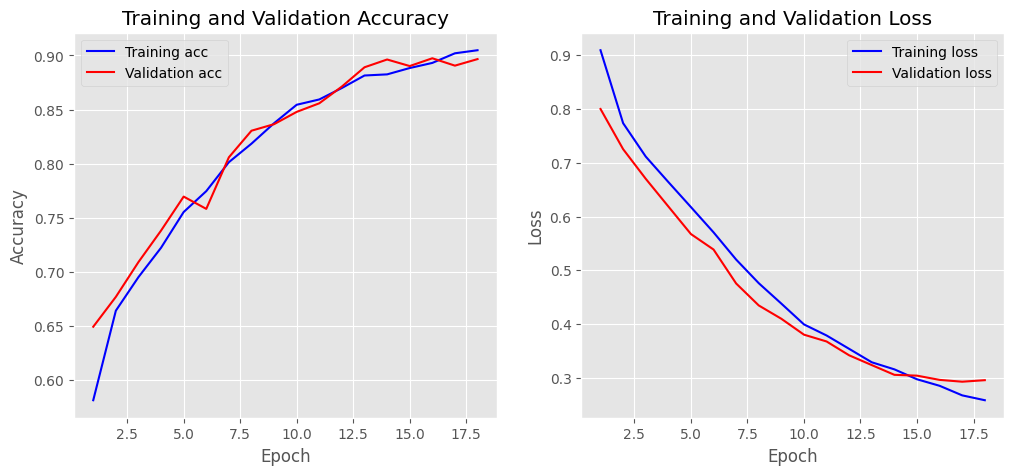

In [14]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [15]:
# menyimpan model

model.save('model.h5')
print("Model has created!")

Model has created!


C:\Users\Reza Fakhrurrozi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
input_text = """Rasa syukur, cukup"""

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('C:/Users/Reza Fakhrurrozi/Documents/GitHub/PlatinumChallange-Group2-/RNN/model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: ", text[0])
print("Sentiment: ", hasil)

1/1 [==============================] - 0s 396ms/step
Text:  rasa syukur  cukup
Sentiment:  positive


In [17]:
input_text = """wajahnya jelek sekali"""

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('C:/Users/Reza Fakhrurrozi/Documents/GitHub/PlatinumChallange-Group2-/RNN/model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: ", text[0])
print("Sentiment: ", hasil)

1/1 [==============================] - 0s 343ms/step
Text:  wajahnya jelek sekali
Sentiment:  neutral
